In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import math

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth specified in decimal degrees using the Haversine formula.
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def calculate_s_values(positions):
    """
    Calculate normalized cumulative distances (s values) for a list of positions.
    Each position is a tuple (latitude, longitude).
    """
    distances = []
    cumulative_distances = [0]  # Start with 0 for the first position

    # Calculate distances between consecutive points
    for i in range(1, len(positions)):
        lat1, lon1 = positions[i - 1]
        lat2, lon2 = positions[i]
        dist = haversine_distance(lat1, lon1, lat2, lon2)
        
        distances.append(dist)
        cumulative_distances.append(cumulative_distances[-1] + dist)

    # Normalize cumulative distances
    total_distance = cumulative_distances[-1]
    
    s_values = [cd / total_distance for cd in cumulative_distances]

    return s_values



In [41]:
# unpickle trips.pkl

trips = pd.read_pickle('trips_100K_dth.pkl')
# trips = pd.read_pickle('trips_100K_msmsa.pkl')
# trips = pd.read_pickle('trips_100K_kswin.pkl')
# trips = pd.read_pickle('trips_100K_naive.pkl')

# trips = pd.read_pickle('trips_downtown_full.pkl')
# trips = pd.read_pickle('trips_downtown_100K_kswin.pkl')
# calculate the MAE of friction and friction_pred for each trip in trips

MAE = []
RMSE = []
for trip in trips[1:]:
    trip_id = np.array(trip[0]).squeeze()
    trip_X = np.array(trip[1]).squeeze()
    trip_y = np.array(trip[2]).squeeze()
    trip_y_pred = np.array(trip[3]).squeeze()
    # print(trip_y.shape, trip_y_pred.shape)
    MAE.append(np.mean(np.abs(trip_y - trip_y_pred)))
    RMSE.append(np.mean((trip_y - trip_y_pred)**2))
    
print('Number of Trips: ', len(trips))
print('MAE: ', np.mean(MAE))
print('RMSE: ', np.mean(np.sqrt(RMSE)))


Number of Trips:  1043
MAE:  0.08046712461029862
RMSE:  0.09731167543769931


MAE: 0.08892629965274966
RMSE: 0.12480823857693377
R^2: 0.5296866588588869


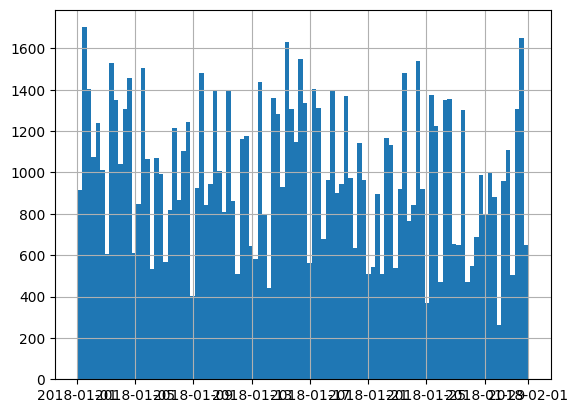

In [7]:
# collect all the records from the trips into a pandas dataframe
df = pd.DataFrame()

for trip in trips:
    trip_id = trip[0]
    trip_X = trip[1]
    trip_y = trip[2]
    trip_y_pred = trip[3]
    trip_mem_size = trip[4]
    # trip_s = calculate_s_values(trip_X[:,1:3])
    
    # convert trip_X to dataframe
    # print(trip_X.shape)
    df_temp = pd.DataFrame(trip_X, columns=['AbsoluteTime','Latitude', 'Longitude','Tsurf', 'Ta','Hours','Speed','Months'])
    # df_temp = pd.DataFrame(trip_X, columns=['AbsoluteTime','Latitude', 'Longitude','Tsurf', 'Ta','Hours','Speed'])
    df_temp['friction'] = trip_y
    df_temp['friction_pred'] = trip_y_pred
    # df_temp['s'] = trip_s
    df_temp['trip_id'] = trip_id
    df_temp['trip_mem_size'] = trip_mem_size

    df = pd.concat([df, df_temp])

df['abs_error'] = abs(df['friction'] - df['friction_pred'])
df['sqrd_error'] = (df['friction'] - df['friction_pred'])**2

# print MAE and RMSE of all records
print('MAE:', df['abs_error'].mean())
print('RMSE:', np.sqrt(df['sqrd_error'].mean()))
# print R^2 of all records
print('R^2:', 1 - np.sum(df['sqrd_error'])/np.sum((df['friction'] - df['friction'].mean())**2))

# convert AbsoluteTime to datetime where the first record is 2018-01-01
df['DateTime'] = pd.to_datetime(df['AbsoluteTime'], unit='s', origin='2018-01-01')

lat_bound = [60.15, 60.55]
lon_bound = [24.7, 25.10]
# select only records within the lat and lon bounds
# df = df[(df['Latitude'] > lat_bound[0]) & (df['Latitude'] < lat_bound[1])]

# plot a histogram of records vs datatime
df['DateTime'].hist(bins=100)


# Set 'Datetime' as the index
df.set_index('DateTime', inplace=True)

# Resample by week, creating a list of DataFrames
weekly_dfs = [group for _, group in df.resample('W')]

In [8]:
%matplotlib qt

plt.close('all')
virgin = True
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for trip in trips[1:]:
    
    
    if len(trip[2]) < 100:
        continue
        
    trip_id = trip[0]
    trip_X = trip[1]
    trip_y = trip[2]
    trip_y_pred = trip[3]
    trip_mem_size = trip[4]
    trip_s = calculate_s_values(trip_X[:,1:3])

    # convert trip_X to dataframe
    # print(trip_X.shape)
    df = pd.DataFrame(trip_X, columns=['AbsoluteTime','Latitude', 'Longitude','Tsurf', 'Ta','Hours','Speed','Months'])
    # df = pd.DataFrame(trip_X, columns=['AbsoluteTime','Latitude', 'Longitude','Tsurf', 'Ta','Hours','Speed'])

   # convert trip_X to dataframe
    # df = pd.DataFrame(trip_X, columns=['Latitude', 'Longitude'])
    df['AbsoluteTime'] = df['AbsoluteTime'] - df['AbsoluteTime'].min()
    df['friction'] = trip_y
    df['friction_pred'] = trip_y_pred
    df['s'] = trip_s

    # create subplots

    ax[0].cla()
    ax[1].cla()
    ax[2].cla()

    # # scatter plot of friction in a lat long 2D space
    # sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='friction', ax=ax[0], s=10, palette='Spectral', hue_norm=(0.1,.9),legend=False)
    # ax[0].set_title('Measured - '+str(trip_id))

    # # scatter plot of friction in a lat long 2D space
    # sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='friction_pred', ax=ax[1], s=10, palette='Spectral', hue_norm=(0.1,.9), legend=False)
    # ax[1].set_title('Predicted - '+str(trip_id))

    # scatter plot of friction in a lat long 2D space using plt
    sc = ax[0].scatter(df['Longitude'], df['Latitude'], c=df['friction'], cmap='viridis', s=3, alpha=0.7, vmin=.6, vmax=.8)
    ax[0].set_title('Measured - trip_id:'+str(trip_id))
    
    # scatter plot of friction in a lat long 2D space using plt
    sc = ax[1].scatter(df['Longitude'], df['Latitude'], c=df['friction_pred'], cmap='viridis', s=3, alpha=0.7, vmin=.6, vmax=.8)
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_title('Predicted')
    # ax[0].set_xlim(23.1, 24.10)
    # ax[0].set_ylim(60.30, 60.45)

    # ax[1].set_xlim(23.1, 24.10)
    # ax[1].set_ylim(60.30, 60.45)
    if virgin:
        virgin = False


        # add colorbar to the scatter plot
        fig.colorbar(sc, ax=ax[0], label='Friction')
        fig.colorbar(sc, ax=ax[1], label='Friction')
        fig.tight_layout()

    # plot friction over time using plt
    ax[2].plot(df['s'], df['friction'], label='Measured')
    ax[2].plot(df['s'], df['friction_pred'], label='Predicted')
    # ax[2].set_title('Measured vs. Predicted - '+str(trip_id) + ' - ' + str(trip[1][0,0]))
    ax[2].set_title('Friction (Measured vs. Predicted)')
    ax[2].legend()
    ax[2].set_xlabel('Station (s)')
    ax[2].set_ylabel('Friction')

    # make ylim .2 to 08
    ax[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.pause(0.01)

    # save the png figure in \figures directory
    plt.savefig('figures/fig_'+str(trip_id)+'_kswin.png')
    # if key n is pressed, go to next trip
    if plt.waitforbuttonpress():            
        continue


KeyboardInterrupt: 

In [9]:
# scatter the friction values in a lat long 2D space using seaborn
# for df_ in weekly_dfs:

for df_ in [df]:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # scatter plot of friction in a lat long 2D space
    sns.scatterplot(x='Longitude', y='Latitude', data=df_, hue='friction', ax=ax[0], s=10, palette='Spectral', hue_norm=(0.1,.9), alpha=0.2, edgecolor=None)
    sns.scatterplot(x='Longitude', y='Latitude', data=df_, hue='friction_pred', ax=ax[1], s=10, palette='Spectral', hue_norm=(0.1,.9), alpha=0.2, edgecolor=None)
    sns.scatterplot(x='Longitude', y='Latitude', data=df_, hue='abs_error', ax=ax[2], s=10, palette='Spectral', hue_norm=(0.1,.9), alpha=0.2, edgecolor=None)
    # set title of the figure
    fig.suptitle('Weekly Friction')

ValueError: Could not interpret value `abs_error` for `hue`. An entry with this name does not appear in `data`.

In [16]:
# Define the number of bins
num_bins_x = 200
num_bins_y = 200
    
# Function to create heatmap data
def create_heatmap_data(x, y, values, num_bins_x, num_bins_y):
    x_bins = np.linspace(x.min(), x.max(), num_bins_x+1)
    y_bins = np.linspace(y.min(), y.max(), num_bins_y+1)
    heatmap, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=values, density=False)
    counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    mean_heatmap = heatmap / counts
    mean_heatmap = np.nan_to_num(mean_heatmap)  # Convert NaNs to zero where counts are zero
    return mean_heatmap.T  # Transpose to match the coordinate system

# fig, ax = plt.subplots(len(weekly_dfs), 3, figsize=(15, 5))
fig, ax = plt.subplots(5, 3, figsize=(15, 5))

for i, df_ in enumerate(weekly_dfs):
# for i, df_ in enumerate([weekly_dfs[0], df]):
    # Creating heatmaps for each variable
    friction_heatmap = create_heatmap_data(df_['Longitude'], df_['Latitude'], df_['friction'], num_bins_x, num_bins_y)
    friction_pred_heatmap = create_heatmap_data(df_['Longitude'], df_['Latitude'], df_['friction_pred'], num_bins_x, num_bins_y)
    abs_error_heatmap = create_heatmap_data(df_['Longitude'], df_['Latitude'], df_['abs_error'], num_bins_x, num_bins_y)
    # normalize abs_error_heatmap to have mean 0 and std 1
    # abs_error_heatmap = (abs_error_heatmap - np.mean(abs_error_heatmap)) / np.std(abs_error_heatmap)


    # Plotting
    
    cmaps = 'viridis'  # Choose a colormap that suits your data

    ax[i,0].imshow(friction_heatmap, aspect='auto', origin='lower', extent=[df_['Longitude'].min(), df_['Longitude'].max(), df_['Latitude'].min(), df_['Latitude'].max()], cmap=cmaps, vmin=0.2, vmax=0.8)
    ax[i,0].set_title('Mean Friction')
    ax[i,0].set_xlabel('Longitude')
    ax[i,0].set_ylabel('Latitude')

    ax[i,1].imshow(friction_pred_heatmap, aspect='auto', origin='lower', extent=[df_['Longitude'].min(), df_['Longitude'].max(), df_['Latitude'].min(), df_['Latitude'].max()], cmap=cmaps, vmin=0.2, vmax=0.8)
    ax[i,1].set_title('Mean Predicted Friction')
    ax[i,1].set_xlabel('Longitude')
    ax[i,1].set_ylabel('Latitude')

    ax[i,2].imshow(abs_error_heatmap, aspect='auto', origin='lower', extent=[df_['Longitude'].min(), df_['Longitude'].max(), df_['Latitude'].min(), df_['Latitude'].max()], cmap=cmaps, vmin=0.0, vmax=0.8)
    ax[i,2].set_title('Mean Absolute Error')
    ax[i,2].set_xlabel('Longitude')
    ax[i,2].set_ylabel('Latitude')

    # plt.tight_layout()
    plt.show()

C:\Users\Hossein_Haeri\AppData\Local\Temp\ipykernel_32564\3872474523.py:11: RuntimeWarning: invalid value encountered in divide
  mean_heatmap = heatmap / counts


In [31]:
# print number of records in all the trips
print(np.sum([len(trip[1]) for trip in trips]))

print(len(trips))


88249
4352
